In [1]:
student_id =  "98101771"
student_name = "Morteza Seyedi"

print("your student id:", student_id)
print("your name:", student_name)

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize, Lambda
from torch import nn
from tqdm import trange
import matplotlib.pyplot as plt
from keras.metrics import Accuracy, Precision

device = 'cuda' if torch.cuda.is_available() else 'cpu'

your student id: 98101771
your name: Morteza Seyedi


<div dir="rtl">
<font face="B Nazanin" size="5">
برای شبکه تعداد لایه های متعددی می توانیم در نظر بگیریم، در اینجا به دو لایه بسنده می کنیم
این دو لایه مستقل از هم ترین خواهند شد، به همین علت آن ها را در دو کلاس مجزا قرار می دهیم
</font>
</div>

model :

In [2]:
class Forward_Forward_1(nn.Module):
    def __init__(self):
        super(Forward_Forward_1, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(28*28, 1000),
            nn.ReLU(),
        )
    def forward(self, x):
        x = self.fc1(x)
        return x
    
class Forward_Forward_2(nn.Module):
    def __init__(self):
        super(Forward_Forward_2, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(1000, 500),
            nn.ReLU(),
        )
    def forward(self, x):
        x = self.fc1(x)
        return x

<div dir="rtl">
<font face="B Nazanin" size="5">
در این جا دو دیتاست مثبت و منفی را تشکیل می دهیم
</font>
</div>

Supervised :

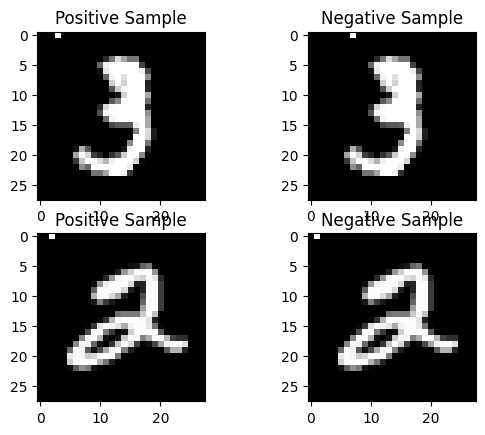

In [3]:
# loading the data and preprocessing
transforms = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,)),
    Lambda(lambda x: torch.flatten(x))
])

pos_train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms
)

neg_train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms
)

pos_train_data.data[:, 0, :10] = 255 * torch.nn.functional.one_hot(pos_train_data.targets)
neg_y_one_hot = torch.nn.functional.one_hot(neg_train_data.targets)
for j in range(len(neg_y_one_hot)):
    random_index = torch.randint(0, 10, (1,))
    one_position = torch.argmax(neg_y_one_hot[j])
    while random_index == one_position:
        random_index = torch.randint(0, 10, (1,))
    neg_y_one_hot[j][random_index] = 255
    neg_y_one_hot[j][one_position] = 0

neg_train_data.data[:, 0, :10] = neg_y_one_hot

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(pos_train_data.data[10], cmap='gray')
axs[0, 0].set_title('Positive Sample')
axs[0, 1].imshow(neg_train_data.data[10], cmap='gray')
axs[0, 1].set_title('Negative Sample')
axs[1, 0].imshow(pos_train_data.data[5], cmap='gray')
axs[1, 0].set_title('Positive Sample')
axs[1, 1].imshow(neg_train_data.data[5], cmap='gray')
axs[1, 1].set_title('Negative Sample')
plt.show()

<div dir="rtl">
<font face="B Nazanin" size="5">
برای این که تابع هزینه کاهش یابد یا باید گودنس دیتاهای مثبت زیاد شود و یا باید گودنس دیتاهای منفی کم شود
ویژگی تابع گودنس هم به همین صورت بود که برای داده های مثبت بیشینه و برای داده های منفی کمینه شود
در نهایت که هزینه کمینه می شود شروط تابع گودنس هم برقرار خواهند شد.
برای آموزش شبکه به صورت زیر عمل میکنیم، شافل را برای دیتا لودر ها خاموش می کنیم تا ترتیب دیتا های متناظر مثبت و منفی به هم نریزد
بعد از آن برای لایه اول روند ترینینگ همان روند معمول است، خروجی را گرفته و لاس را حساب می کنیم و وزن ها را آپدیت می کنیم
برای لایه دوم اما باید به دو نکته توجه کنیم ، اول آن که تنسور ورودی به آن ، تنسور خروجی از لایه قبلی است و computational graph قبلی را در دل خود دارد.
برای آن که این امر درست شود و تنسور به یک تنسور عادی تبدیل شود از detach() استفاده می کنیم.
نکته دوم این که خروجی باید نرمالایز بشود که همین طور عمل می کنیم
</font>
</div>

In [4]:
# training one layer of forward forward
ff_layer1 = Forward_Forward_1().to(device)
ff_layer2 = Forward_Forward_2().to(device)

threshold = 2
batch_size = 1000
epochs = 20
optimizer1 = torch.optim.Adam(ff_layer1.parameters(), lr=0.003)
optimizer2 = torch.optim.Adam(ff_layer2.parameters(), lr=0.003)
pos_train_loader = DataLoader(pos_train_data, batch_size=batch_size, shuffle=False)
neg_train_loader = DataLoader(neg_train_data, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    for i, (pos_data, neg_data) in enumerate(zip(pos_train_loader, neg_train_loader)):
        pos_data = pos_data[0].to(device)
        neg_data = neg_data[0].to(device)
        
        # first layer
        optimizer1.zero_grad()
        layer1_output_pos = ff_layer1(pos_data)
        layer1_output_neg = ff_layer1(neg_data)

        G_pos = layer1_output_pos.pow(2).mean(dim = 1)
        G_neg = layer1_output_neg.pow(2).mean(dim = 1)

        loss1 = torch.log(1 + torch.exp(torch.cat([threshold - G_pos, G_neg - threshold]))).mean()
        loss1.backward()
        optimizer1.step()

        # second layer
        layer1_output_pos = layer1_output_pos.detach()
        layer1_output_neg = layer1_output_neg.detach()
        layer1_output_pos = layer1_output_pos / (layer1_output_pos.norm(2, 1, keepdim=True) + 1e-3)
        layer1_output_neg = layer1_output_neg / (layer1_output_neg.norm(2, 1, keepdim=True) + 1e-3)
        optimizer2.zero_grad()
        layer2_output_pos = ff_layer2(layer1_output_pos)
        layer2_output_neg = ff_layer2(layer1_output_neg)

        G_pos = layer2_output_pos.pow(2).mean(dim = 1)
        G_neg = layer2_output_neg.pow(2).mean(dim = 1)

        loss2 = torch.log(1 + torch.exp(torch.cat([threshold - G_pos, G_neg - threshold]))).mean()
        loss2.backward()
        optimizer2.step()
    
    print(f'epoch: {epoch}, loss1: {loss1.item()}, loss2: {loss2.item()}')

epoch: 0, loss1: 0.5576398372650146, loss2: 0.7420791387557983
epoch: 1, loss1: 0.42068374156951904, loss2: 0.6882595419883728
epoch: 2, loss1: 0.35006317496299744, loss2: 0.6007192730903625
epoch: 3, loss1: 0.3078485429286957, loss2: 0.5307058095932007
epoch: 4, loss1: 0.27850663661956787, loss2: 0.4746510088443756
epoch: 5, loss1: 0.2554832398891449, loss2: 0.4327651262283325
epoch: 6, loss1: 0.23671481013298035, loss2: 0.4013923704624176
epoch: 7, loss1: 0.2210170179605484, loss2: 0.3761962354183197
epoch: 8, loss1: 0.2077002078294754, loss2: 0.3541034162044525
epoch: 9, loss1: 0.196309894323349, loss2: 0.33496540784835815
epoch: 10, loss1: 0.18640276789665222, loss2: 0.31977009773254395
epoch: 11, loss1: 0.17755724489688873, loss2: 0.308880090713501
epoch: 12, loss1: 0.1695321500301361, loss2: 0.3013632595539093
epoch: 13, loss1: 0.1622920036315918, loss2: 0.29578229784965515
epoch: 14, loss1: 0.15580227971076965, loss2: 0.29121553897857666
epoch: 15, loss1: 0.149972066283226, loss

<div dir="rtl">
<font face="B Nazanin" size="5">
برای انجام تست به این گونه عمل میکنیم :
به هر داده لیبل های 0 تا 9 را اضافه میکنیم و به شبکه می دهیم، هر ترکیب داده و لیبلی که بیشترین گودنس را داشته باشد همان پردیکشن شبکه است.
</font>
</div>

In [5]:
# making a full classifier with the forward forward

for param in ff_layer1.parameters():
    param.requires_grad = False
for param in ff_layer2.parameters():
    param.requires_grad = False

class Forward_Forward(nn.Module):
    def __init__(self):
        super(Forward_Forward, self).__init__()
        self.forward_forward_1 = ff_layer1
        self.forward_forward_2 = ff_layer2
    def forward(self, x):
        x = self.forward_forward_1(x)
        x = self.forward_forward_2(x)
        return x

model2 = Forward_Forward().to(device)

train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms 
)
test_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
label = []
prediction = []

with torch.no_grad():
    for data, target in test_loader:
        data_0 = data.clone()
        data_0.data[:,0] = 2.821
        data_0 = data_0.to(device)
        data_1 = data.clone()
        data_1.data[:,1] = 2.821
        data_1 = data_1.to(device)
        data_2 = data.clone()
        data_2.data[:,2] = 2.821
        data_2 = data_2.to(device)
        data_3 = data.clone()
        data_3.data[:,3] = 2.821
        data_3 = data_3.to(device)
        data_4 = data.clone()
        data_4.data[:,4] = 2.821
        data_4 = data_4.to(device)
        data_5 = data.clone()
        data_5.data[:,5] = 2.821
        data_5 = data_5.to(device)
        data_6 = data.clone()
        data_6.data[:,6] = 2.821
        data_6 = data_6.to(device)
        data_7 = data.clone()
        data_7.data[:,7] = 2.821
        data_7 = data_7.to(device)
        data_8 = data.clone()
        data_8.data[:,8] = 2.821
        data_8 = data_8.to(device)
        data_9 = data.clone()
        data_9.data[:,9] = 2.821
        data_9 = data_9.to(device)

        goodness_0 = model2(data_0).pow(2).mean(dim = 1)
        goodness_1 = model2(data_1).pow(2).mean(dim = 1)
        goodness_2 = model2(data_2).pow(2).mean(dim = 1)
        goodness_3 = model2(data_3).pow(2).mean(dim = 1)
        goodness_4 = model2(data_4).pow(2).mean(dim = 1)
        goodness_5 = model2(data_5).pow(2).mean(dim = 1)
        goodness_6 = model2(data_6).pow(2).mean(dim = 1)
        goodness_7 = model2(data_7).pow(2).mean(dim = 1)
        goodness_8 = model2(data_8).pow(2).mean(dim = 1)
        goodness_9 = model2(data_9).pow(2).mean(dim = 1)
        
        goodness = torch.stack((goodness_0, goodness_1, goodness_2, goodness_3, goodness_4, goodness_5, goodness_6, goodness_7, goodness_8, goodness_9), dim=1)
        predicted = torch.argmax(goodness, dim=1)
        label += target.tolist()
        prediction += predicted.tolist()

print(f'train data accuracy: {Accuracy()(label, prediction)}')
print(f'train data precision: {Precision()(label, prediction)}')

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms 
)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
label = []
prediction = []
with torch.no_grad():
    for data, target in test_loader:
        data_0 = data.clone()
        data_0.data[:,0] = 2.821
        data_0 = data_0.to(device)
        data_1 = data.clone()
        data_1.data[:,1] = 2.821
        data_1 = data_1.to(device)
        data_2 = data.clone()
        data_2.data[:,2] = 2.821
        data_2 = data_2.to(device)
        data_3 = data.clone()
        data_3.data[:,3] = 2.821
        data_3 = data_3.to(device)
        data_4 = data.clone()
        data_4.data[:,4] = 2.821
        data_4 = data_4.to(device)
        data_5 = data.clone()
        data_5.data[:,5] = 2.821
        data_5 = data_5.to(device)
        data_6 = data.clone()
        data_6.data[:,6] = 2.821
        data_6 = data_6.to(device)
        data_7 = data.clone()
        data_7.data[:,7] = 2.821
        data_7 = data_7.to(device)
        data_8 = data.clone()
        data_8.data[:,8] = 2.821
        data_8 = data_8.to(device)
        data_9 = data.clone()
        data_9.data[:,9] = 2.821
        data_9 = data_9.to(device)

        goodness_0 = model2(data_0).pow(2).mean(dim = 1)
        goodness_1 = model2(data_1).pow(2).mean(dim = 1)
        goodness_2 = model2(data_2).pow(2).mean(dim = 1)
        goodness_3 = model2(data_3).pow(2).mean(dim = 1)
        goodness_4 = model2(data_4).pow(2).mean(dim = 1)
        goodness_5 = model2(data_5).pow(2).mean(dim = 1)
        goodness_6 = model2(data_6).pow(2).mean(dim = 1)
        goodness_7 = model2(data_7).pow(2).mean(dim = 1)
        goodness_8 = model2(data_8).pow(2).mean(dim = 1)
        goodness_9 = model2(data_9).pow(2).mean(dim = 1)
        
        goodness = torch.stack((goodness_0, goodness_1, goodness_2, goodness_3, goodness_4, goodness_5, goodness_6, goodness_7, goodness_8, goodness_9), dim=1)
        predicted = torch.argmax(goodness, dim=1)
        label += target.tolist()
        prediction += predicted.tolist()

print(f'test data accuracy: {Accuracy()(label, prediction)}')
print(f'test data precision: {Precision()(label, prediction)}')


train data accuracy: 0.937666654586792
train data precision: 0.9985874891281128
test data accuracy: 0.9380000233650208
test data precision: 0.9986626505851746


unsupervised :

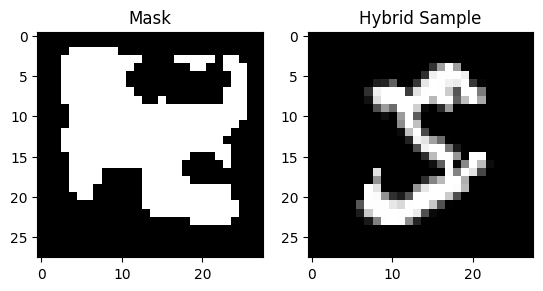

In [6]:
# preprocessing
transforms = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,)),
    Lambda(lambda x: torch.flatten(x))
])

pos_train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms 
)

mask = torch.randint(0, 2, (1, 28, 28), dtype=torch.long)

for i in range(8) :
    mask = torch.nn.functional.conv2d(mask.float(), torch.tensor([[[[0, 0.25, 0], [0, 0.5, 0], [0, 0.25, 0]]]]), padding=1)
    mask = torch.nn.functional.conv2d(mask.float(), torch.tensor([[[[0, 0, 0], [0.25, 0.5, 0.25], [0, 0, 0]]]]), padding=1)
mask = torch.where(mask > 0.5, torch.ones_like(mask), torch.zeros_like(mask))
mask_invert = torch.ones_like(mask) - mask
hybrid_data = pos_train_data.data[0] * mask +  pos_train_data.data[1]* mask_invert

# show the mask and show 2 samples from positive and hybrid datasets
fig, axs = plt.subplots(1, 2)
axs[0].imshow(mask[0], cmap='gray')
axs[0].set_title('Mask')
axs[1].imshow(hybrid_data[0], cmap='gray')
axs[1].set_title('Hybrid Sample')

plt.show()


<div dir="rtl">
<font face="B Nazanin" size="5">
فرآیند train مانند قبل است با این تفاوت که دیتای هیبرید ساخته میشود
برای ساخت دیتای هیبرید ، به اندازه batch_size مسک می سازیم و از آن ها استفاده می کنیم.
استفاده از لایه اول به تنهایی برای ما کافی است و عمل استخراج فیچر را به راحتی انجام می دهد
</font>
</div>

In [12]:
# training one layer of forward forward
ff_layer1 = Forward_Forward_1().to(device)

threshold = 2
batch_size = 1000
epochs = 20
optimizer1 = torch.optim.Adam(ff_layer1.parameters(), lr=0.003)
pos_train_loader = DataLoader(pos_train_data, batch_size=batch_size, shuffle=True)

mask = torch.randint(0, 2, (batch_size,1 , 28, 28), dtype=torch.long).to(device)
for z in range(8) :
    mask = torch.nn.functional.conv2d(mask.float(), torch.tensor([[[[0, 0.25, 0], [0, 0.5, 0], [0, 0.25, 0]]]]).to(device), padding=1)
    mask = torch.nn.functional.conv2d(mask.float(), torch.tensor([[[[0, 0, 0], [0.25, 0.5, 0.25], [0, 0, 0]]]]).to(device), padding=1)
mask = torch.where(mask > 0.5, torch.ones_like(mask), torch.zeros_like(mask))

for epoch in range(epochs):
    for i, (pos_data, target) in enumerate(pos_train_loader):
        pos_data = pos_data.to(device)
        target = target.to(device)
        hybrid_data = pos_data.clone()
        
        for j in range(len(hybrid_data)):
            random_index = torch.randint(0, batch_size, (1,))
            while target[random_index] == target[j]:
                random_index = torch.randint(0, batch_size, (1,))
            mask_invert = torch.ones_like(mask[j]) - mask[j]
            hybrid_data[j] = torch.mul(pos_data[random_index] , torch.flatten(mask[j]))  +  torch.mul(pos_data[j] , torch.flatten(mask_invert))

        # first layer
        optimizer1.zero_grad()
        layer1_output_pos = ff_layer1(pos_data)
        layer1_output_hybrid = ff_layer1(hybrid_data)
        G_pos = layer1_output_pos.pow(2).mean(dim = 1)
        G_neg = layer1_output_hybrid.pow(2).mean(dim = 1)

        loss1 = torch.log(1 + torch.exp(torch.cat([threshold - G_pos, G_neg - threshold]))).mean()
        loss1.backward()
        optimizer1.step()
    
    print(f'epoch: {epoch}, loss1: {loss1.item()}')

epoch: 0, loss1: 0.539238691329956
epoch: 1, loss1: 0.46174392104148865
epoch: 2, loss1: 0.4326189160346985
epoch: 3, loss1: 0.3954436779022217
epoch: 4, loss1: 0.37751710414886475
epoch: 5, loss1: 0.3630721867084503
epoch: 6, loss1: 0.3396013379096985
epoch: 7, loss1: 0.34366855025291443
epoch: 8, loss1: 0.34042060375213623
epoch: 9, loss1: 0.333336740732193
epoch: 10, loss1: 0.31538063287734985
epoch: 11, loss1: 0.3178219497203827
epoch: 12, loss1: 0.3115873634815216
epoch: 13, loss1: 0.30281612277030945
epoch: 14, loss1: 0.30290162563323975
epoch: 15, loss1: 0.3077537715435028
epoch: 16, loss1: 0.29235801100730896
epoch: 17, loss1: 0.28858742117881775
epoch: 18, loss1: 0.27201157808303833
epoch: 19, loss1: 0.281852126121521


<div dir="rtl">
<font face="B Nazanin" size="5">
با افزایش تابع goodness برای دیتا های معتبر و کاهش آن برای دیتاهای هیبرید علملا شبکه در حال یادگیری تشخیص این دو داده از هم است
در نتیجه شبکه از تصویر فیچر هایی استخراج می کند که از آن ها می توان برای classification بهره برد
</font>
</div>

In [13]:
# making a full classifier with the forward forward

for param in ff_layer1.parameters():
    param.requires_grad = False
    
class linear_layer(nn.Module):
    def __init__(self):
        super(linear_layer, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(1000, 10),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.fc1(x)
        return x

train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms 
)

lin = linear_layer().to(device)
optimizer = torch.optim.Adam(lin.parameters(), lr=0.005)
epochs = 20
batch_size = 1000
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
for epoch in range(epochs):
    for i, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        with torch.no_grad():
            data = ff_layer1(data)
        optimizer.zero_grad()
        output = lin(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
    print(f'epoch: {epoch}, loss: {loss.item()}')

# test the model on the test data

for param in lin.parameters():
    param.requires_grad = False

class Forward_Forward_complete(nn.Module):
    def __init__(self):
        super(Forward_Forward_complete, self).__init__()
        self.forward_forward_1 = ff_layer1
        self.forward_forward_2 = lin
    def forward(self, x):
        x = self.forward_forward_1(x)
        x = self.forward_forward_2(x)
        return x

model2 = Forward_Forward_complete().to(device)


test_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
prediction = []
targets = []
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model2(data)
        _, predicted = torch.max(output.data, 1)
        prediction += predicted.tolist()
        targets += target.tolist()

print(f'train data accuracy: {Accuracy()(targets, prediction)}')
print(f'train data precision: {Precision()(targets, prediction)}')

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms 
)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
prediction = []
targets = []
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model2(data)
        _, predicted = torch.max(output.data, 1)
        prediction += predicted.tolist()
        targets += target.tolist()

print(f'test data accuracy: {Accuracy()(targets, prediction)}')
print(f'test data precision: {Precision()(targets, prediction)}')


epoch: 0, loss: 1.5183645486831665
epoch: 1, loss: 1.5135706663131714
epoch: 2, loss: 1.5063550472259521
epoch: 3, loss: 1.5018699169158936
epoch: 4, loss: 1.4981842041015625
epoch: 5, loss: 1.493837594985962
epoch: 6, loss: 1.4934850931167603
epoch: 7, loss: 1.494089126586914
epoch: 8, loss: 1.4971660375595093
epoch: 9, loss: 1.4967373609542847
epoch: 10, loss: 1.4954890012741089
epoch: 11, loss: 1.4991377592086792
epoch: 12, loss: 1.480151653289795
epoch: 13, loss: 1.493973731994629
epoch: 14, loss: 1.4878658056259155
epoch: 15, loss: 1.4946845769882202
epoch: 16, loss: 1.4773205518722534
epoch: 17, loss: 1.4865645170211792
epoch: 18, loss: 1.489432454109192
epoch: 19, loss: 1.4798527956008911
train data accuracy: 0.9795666933059692
train data precision: 0.9992231726646423
test data accuracy: 0.9573000073432922
test data precision: 0.998223602771759


<div dir="rtl">
<font face="B Nazanin" size="5">
شبکه FF برای ما فیچر استخراج می کند اما عمل تشخیص را انجام نمیدهد.
برای تشخیص و classification به یک لایه خطی نیاز داریم که روی فیچر ها آموزش ببیند و train شود.
</font>
</div>